In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
SIZE = 8
img = np.random.rand(SIZE, SIZE, 3) ** 3

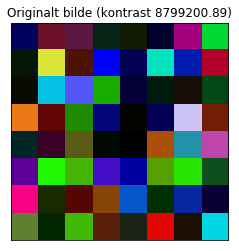

In [3]:
plt.imshow(img)
plt.title("Originalt bilde (kontrast %.2f)" % (img.max() / img.min()))
plt.xticks([])
plt.yticks([])
print()

In [4]:
N = 6

dT = 2**np.arange(1, N + 1)
exs = np.array([(img * 0.1 * dt * 255).clip(0, 255).astype(np.uint8) for dt in dT])

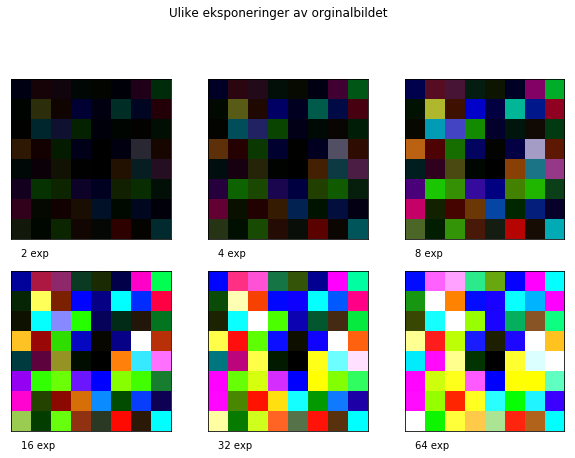

In [5]:
fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.suptitle("Ulike eksponeringer av orginalbildet")

for i, (dt, imge) in enumerate(zip(dT, exs)):
    ax = fig.add_subplot(N // 2, (N + 1) // 2, i + 1, xticks=[], yticks=[])
    ax.imshow(imge)
    ax.text(0, SIZE + .4, '%d exp' % dt)

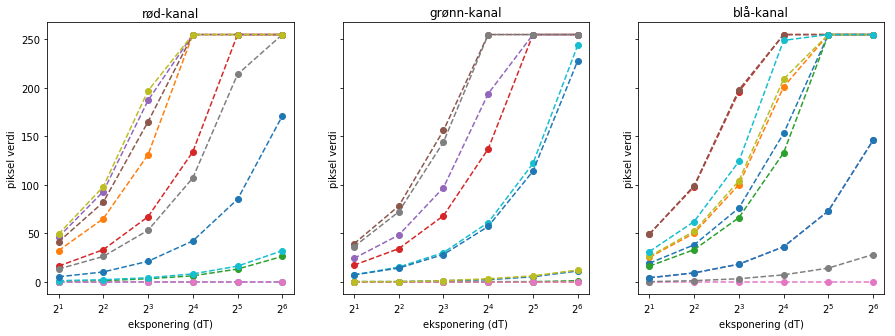

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

for color, ax in zip(['rød', 'grønn', 'blå'], axs):
    ax.set_xlabel('eksponering (dT)')
    ax.set_ylabel('piksel verdi')
    ax.set_title('%s-kanal' % color)
    ax.set_xscale('log', basex=2)

for imge in exs.reshape(N, -1, 3).transpose(1, 2, 0)[::(exs.shape[1] * exs.shape[2]) // 10]:
    for i, eksps in enumerate(imge):
        axs[i].plot(dT, eksps, 'o--')

In [7]:
from hdrie.rekonstruksjon import debevec_maliks

responskurver = [debevec_maliks(kanal, dT, 40, 256) for kanal in exs.transpose(3, 0, 1, 2)]
kanaler = [('r', '-'), ('g', '--'), ('b', '-.')]

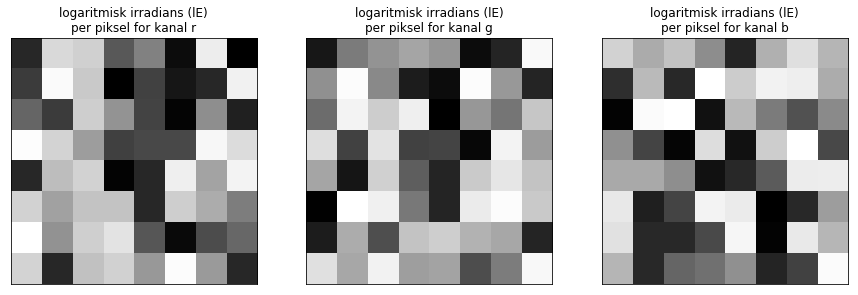

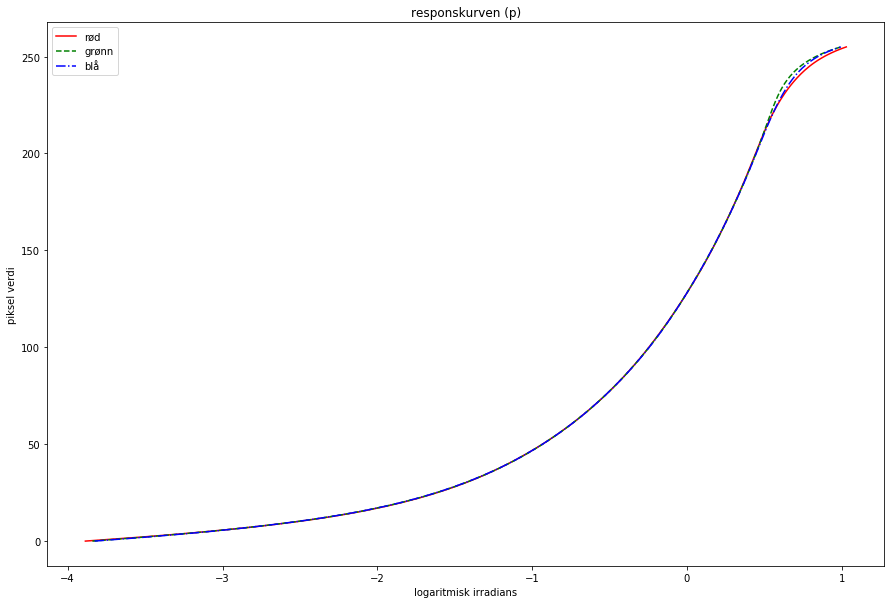

In [8]:
fig_irr = plt.figure(figsize=(15, 10))  # figure size in inches
fig_p = plt.figure(figsize=(15,10))
ax_p = fig_p.add_subplot(1, 1, 1)

for i, ((color, shape), (p, lE)) in enumerate(zip(kanaler, responskurver)):
    ax_irr = fig_irr.add_subplot(1, 3, i + 1, xticks=[], yticks=[])
    ax_irr.imshow(lE, plt.cm.gray)
    ax_irr.set_title('logaritmisk irradians (lE)\nper piksel for kanal %s' % (color))

    ax_p.plot(p, np.arange(256), color + shape)
    
ax_p.set_title('responskurven (p)')
ax_p.set_ylabel('piksel verdi')
ax_p.set_xlabel('logaritmisk irradians')
ax_p.legend(['rød', 'grønn', 'blå'])

In [9]:
from hdrie.rekonstruksjon import rekonstruer_irradians
lE = []
for (p, _), ex in zip(responskurver, exs.transpose(3, 0, 1, 2)):
    lE.append(rekonstruer_irradians(ex, dT, p, 256))
lE = np.array(lE)
lE = lE.transpose(1, 2, 0)

In [10]:
print("Forventet: ", img.min(), img.max(), abs(img.max() / img.min()))

kons = np.exp(lE)
print("Rekonstruert: ", kons.min(), kons.max(), abs(kons.max() / kons.min()))

Forventet:  1.1216087870331695e-07 0.9869261042584768 8799200.894895364
Rekonstruert:  0.0012350011667192856 0.19398419428068872 157.07207370175797


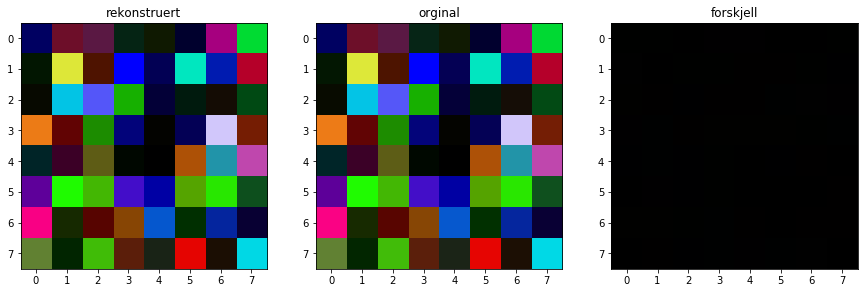

In [11]:
def scale(m, r=(0, 1)):
    new_min, new_max = r
    return new_min + (((m - m.min()) * new_max) / (m.max() - m.min()))

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].set_title('rekonstruert')
axs[0].imshow(scale(kons), plt.cm.gray, vmin=0, vmax=1)
axs[1].set_title('orginal')
axs[1].imshow(scale(img), plt.cm.gray, vmin=0, vmax=1)
axs[2].set_title('forskjell')
axs[2].imshow(np.abs(scale(kons) - scale(img)), plt.cm.gray, vmin=0, vmax=1)